The comma.ai Programming Challenge:
======

<br>

### The goal of this challenge is to build a machine learning computer vision model that can predict the speed of a car from a video taken from inside.*

<br>

- data/train.mp4 is a video of driving containing 20400 frames. Video is shot at 20 fps.
- data/train.txt contains the speed of the car at each frame, one speed on each line.
- data/test.mp4 is a different driving video containing 10798 frames. Video is shot at 20 fps.

Deliverable
-----

Your deliverable is test.txt. E-mail it to givemeajob@comma.ai, or if you think you did particularly well, e-mail it to George.

Evaluation
-----

We will evaluate your test.txt using mean squared error. <10 is good. <5 is better. <3 is heart.

<br>

[*See the original repo for the original wording](https://github.com/commaai/speedchallenge)

# My Solution:
Since the amount of training data is so small, only about twenty thousand frames, which is less than the few hundred thousand I'd accept as a minimum, I think that neural networks are out of the question.

It would be possible to pretrain a neural network with external data sources and then tune the model on the test video, but don't think it's enough data, even to tune a pretrained model. In any case, I don't want to go that route. I think it's against the spirit of the competition.

Instead, let's fall back to traditional Computer Vision methods. Let's use a keypoint extraction algorithm (Oriented FAST and Rotated BRIEF) to track objects and points of interest, then train a regression model (TODO Choose regression model) to predict the speed of the car based on how far each matching keypoint moves.

# Preprocessing

## Rip frames
Export each frame of the video as an image. This may take a while.

## Crop
In the provided training video (and presumably the video this will be tested on), the hood and tinted upper bit of the windshield obscure the view. Only an area of roughly (640, 320) with its upper corner at (0, 34) is useful.

## Slicing
We have no labels for our test dataset. To ensure that our model is accurate and can generalize well to the testing video, we need to reserve some more labeled data to validate it on. To double the number of examples, we can slice the cropped image in half, yielding two (320, 320) square images. We'll reserve a small portion of our training videofor validating our model.

In [1]:
import os
from time import time
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import pickle
import numpy as np
%matplotlib inline

In [2]:
# For the first run, set both of these to True.

# Rip the video into frames, then crop and slice.
preprocess = False 

# Extract image features from the sliced crops
extract    = False

### Rip Frames

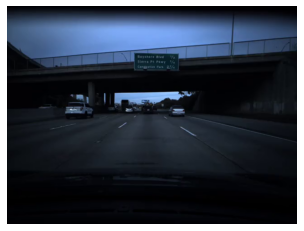

In [3]:
num_trainframes = 20400
num_testframes = 10798

# Create a folder if it doesn't exist
def mkdir(dir):
    try:
        os.mkdir(dir)
    except:
        pass

def video_to_frames(input_loc, output_loc):
    mkdir(output_loc)
    os.system(f'ffmpeg -i {input_loc} {output_loc}/%d_full.png')

if preprocess:
    video_to_frames('data/train.mp4', 'data/trainframes')
    print("Ripped frames from train video.")
    video_to_frames('data/test.mp4',  'data/testframes')
    print("Ripped frames from test video.")


# Show the first frame of the video file
def showFirstFrame(videofile):
    _, image = cv2.VideoCapture(videofile).read()
    #cv2.imshow(image)  # save frame as JPEG file
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
showFirstFrame('data/train.mp4')

### Crop and Slice

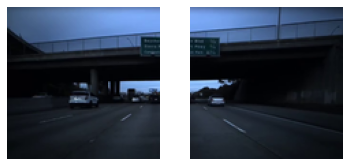

In [4]:
# Top left corner: (0, 34)
# Width/Height: (640, 320)
cropleft = (0, 34, 320, 320+34)
cropright = (320, 34, 640, 320+34)
width, height = (112,112)

if preprocess:
    for i in trange(0, num_trainframes):
        framepath = f'data/trainframes/{i+1}_full.png'

        img = Image.open(framepath)
        img.crop(cropleft).save(f'data/trainframes/{i}_left.png')
        img.crop(cropright).save(f'data/trainframes/{i}_right.png')
        os.remove(framepath)
    
    for i in trange(0, num_testframes):
        framepath = f'data/testframes/{i+1}_full.png'

        img = Image.open(framepath)
        img.crop(cropleft).save(f'data/testframes/{i}_left.png')
        img.crop(cropright).save(f'data/testframes/{i}_right.png')
        os.remove(framepath)

def showCroppedSlicedFrame():
    plt.subplot(1, 2, 1)
    plt.imshow(Image.open('data/trainframes/1_left.png'));
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(Image.open('data/trainframes/1_right.png'));
    plt.axis('off')
    plt.show()
showCroppedSlicedFrame()

# Extract Image Features
I'll be using a computer vision algorithm known as [ORB (Oriented FAST and Rotated BRIEF)](https://doi.org/10.1109/ICCV.2011.6126544) to extract keypoints and feature descriptor vectors from the images.

Keypoints and feature vectors are extremely useful for object detection, recognition, and tracking tasks. It should hopefully allow us to pinpoint the position of objects as we're driving down the road, by tracking the location of the object through each frame. The distance that each keypoint moves for each frame should give us a good idea of how fast we're going. 

In [5]:
# Initialize OpenCV's implementation of ORB
ORB = cv2.ORB_create()

# Try to create the output folder if it doesn't exist.
mkdir('data/trainfeatures/')
mkdir('data/testfeatures/')

def extract_features_and_keypoints(in_fname, out_fname):
    # Open the image
    img = cv2.imread(in_fname, 1)

    # Compute the keypoints and descriptor vectors
    kps, des = ORB.detectAndCompute(img, None)

    # Handle cases where no keypoints were found
    des = [] if not len(kps) else des
    if not len(des):
        print(f'{in_fname} has no keypoints.')
        

    # Convert to a nicer format to store
    kps = [(point.pt, point.size, point.angle, point.response, point.octave, point.class_id, desc) for point, desc in zip(kps, des)]

    # Save the results
    with open(out_fname, 'wb') as f:
        pickle.dump(kps, f)

# Extract the features and keypoints for all our images
if extract:
    for i in range(num_trainframes):
        extract_features_and_keypoints(f'data/trainframes/{i}_left.png', f'data/trainfeatures/{i}_left.kpv')
        extract_features_and_keypoints(f'data/trainframes/{i}_right.png', f'data/trainfeatures/{i}_right.kpv')
    for i in range(num_testframes):
        extract_features_and_keypoints(f'data/testframes/{i}_left.png', f'data/testfeatures/{i}_left.kpv')
        extract_features_and_keypoints(f'data/testframes/{i}_right.png', f'data/testfeatures/{i}_right.kpv')


In [6]:
def load_features_and_keypoints(fname):
    with open(fname, 'rb') as f:
        loaded = pickle.load(f)
        kps = [cv2.KeyPoint(x=point[0][0],y=point[0][1],_size=point[1], _angle=point[2], _response=point[3], _octave=point[4], _class_id=point[5]) for point in loaded]
        des = np.array([point[6] for point in loaded])
        return kps, des


# Load the features into memory
train_left_features  = [ load_features_and_keypoints(f'data/trainfeatures/{i}_left.kpv')  for i in range(num_trainframes) ]
train_right_features = [ load_features_and_keypoints(f'data/trainfeatures/{i}_right.kpv') for i in range(num_trainframes) ]
test_left_features   = [ load_features_and_keypoints(f'data/testfeatures/{i}_left.kpv')   for i in range(num_testframes)  ]
test_right_features  = [ load_features_and_keypoints(f'data/testfeatures/{i}_right.kpv')  for i in range(num_testframes)  ]

# Hold back validation set
valid_features = [train_right_features[i] for i in range(len(train_right_features)//2, len(train_right_features))]


# Display the first frame split with its keypoints.
#img = cv2.imread()
#img = cv2.drawKeypoints(img, kp, None)
#plt.imshow()
#plt.axis('off')
#plt.show()

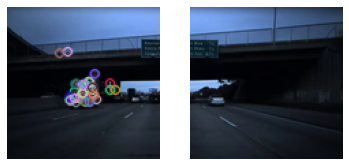

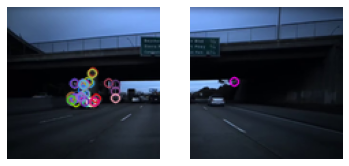

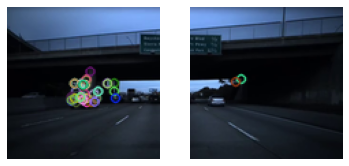

In [7]:
def showCroppedSlicedFeatureExtractedFrame(i):
    # Load image and change color space
    left_img  = cv2.imread(f'data/trainframes/{i}_left.png', 1)
    right_img = cv2.imread(f'data/trainframes/{i}_right.png', 1)

    left_img  = cv2.cvtColor(left_img, cv2.COLOR_BGR2RGB)
    right_img = cv2.cvtColor(right_img, cv2.COLOR_BGR2RGB)

    # Load keypoints and descriptors
    left_kp, left_des   = train_left_features[i]
    right_kp, right_des = train_right_features[i]

    # Paste the keypoints onto the image
    left_img  = cv2.drawKeypoints(left_img, left_kp, None)
    right_img = cv2.drawKeypoints(right_img, right_kp, None)

    # Display the image
    plt.subplot(1, 2, 1)
    plt.imshow(left_img);
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(right_img);
    plt.axis('off')
    plt.show()

showCroppedSlicedFeatureExtractedFrame(0)
showCroppedSlicedFeatureExtractedFrame(1)
showCroppedSlicedFeatureExtractedFrame(2)

As you can see, not all the same keypoints are detected in every frame. This is fine however. The descriptor vector for each keypoint keeps track of the relevant contextual information.

## Find Frames that are missing keypoints

In [8]:
def find_missing(features):
    return [i for i in range(len(features)) if not len(features[i][1])]

mtrainleft  = find_missing(train_left_features)
mtrainright = find_missing(train_right_features)
mtestleft   = find_missing(test_left_features)
mtestright  = find_missing(test_right_features)

print(f'Missing ({len(mtrainleft)}, {len(mtrainright)}) frames of features from each side of the training data.')
print(f'Missing ({len(mtestleft)},  {len(mtestright)}) frames of features from each side of the testing data.')
print()
print(f'Missing left train features:  ', mtrainleft)
print(f'Missing right train features: ', mtrainright)
print(f'Missing left test features:   ', mtestleft)
print(f'Missing right test features:  ', mtestright)
print()
print('Missing from both left and right train: ', [i for i in mtrainleft if i in mtrainright])
print('Missing from both left and right test:  ', [i for i in mtestleft if i in mtestright])

Missing (52, 43) frames of features from each side of the training data.
Missing (7,  3) frames of features from each side of the testing data.

Missing left train features:   [14396, 14397, 14408, 14410, 14411, 14428, 14429, 14452, 14453, 14456, 14457, 14458, 14459, 14710, 14714, 14715, 14716, 14735, 14736, 14737, 14738, 14739, 14740, 14741, 14742, 14743, 14744, 14745, 14747, 14748, 14752, 14753, 14754, 14755, 14756, 14757, 14758, 14759, 14760, 14761, 14762, 14763, 14764, 14765, 14766, 14767, 14768, 14769, 14770, 14772, 14773, 14774]
Missing right train features:  [0, 11934, 11937, 11938, 12340, 12361, 12363, 12364, 12365, 12366, 12367, 12368, 12369, 12370, 12371, 12372, 12373, 12374, 12375, 12376, 12378, 12379, 12380, 12382, 12383, 12384, 12385, 12386, 12387, 12388, 12389, 12390, 12392, 12394, 17220, 17221, 17222, 17223, 17224, 17225, 17226, 17227, 17229]
Missing left test features:    [188, 712, 713, 714, 715, 716, 718]
Missing right test features:   [4546, 4547, 4549]

Missing from

You'll notice here that ORB failed to extract keypoints and descriptor vectors from some of the images. However, note that we still have at least one keypoint for each frame. If the right side of the frame doesn't have any features, the left does.

We always have at least one keypoint to work with.

## Slice up the usable parts of each video

## Generate training examples

### Load labels

In [9]:
# Load the label file
labels = []
with open('data/train.txt') as f:
    labels = f.readlines()
labels = [ float(label.strip()) for label in labels ]

print(f'min: {min(labels)}, max: {max(labels)}, avg: {sum(labels)/len(labels)}')

min: 0.0, max: 28.130404, avg: 12.18318166044118
